# Detecció d'opinions

In [49]:
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews as mr
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.sentiment import SentimentIntensityAnalyzer



[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Edu\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [50]:
for cat in mr.categories():
    print(cat, len(mr.fileids(cat)))

neg 1000
pos 1000


In [51]:
def preprocess(review):
    review = review.lower()
    # eliminate any character that is not a letter or a space
    review = ''.join(c for c in review if c.isalpha() or c == ' ')
    review = review.replace('\n', ' ')
    # convert all the words to its lemma
    lemmatizer = nltk.WordNetLemmatizer()
    review = ' '.join(lemmatizer.lemmatize(word) for word in review.split())

    return review

In [52]:
# create a CountVectorizer instance
vectorizer = CountVectorizer()
y = ["pos"]*1000 + ["neg"]*1000 
corpus = []
for rev in mr.fileids():
    corpus.append(preprocess(mr.raw(rev)))

In [53]:
print(corpus[0])
X = vectorizer.fit_transform(corpus)
print(len(y))
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


plot two teen couple go to a church party drink and then drive they get into an accident one of the guy dy but his girlfriend continues to see him in her life and ha nightmare whats the deal watch the movie and sorta find out critique a mindfuck movie for the teen generation that touch on a very cool idea but present it in a very bad package which is what make this review an even harder one to write since i generally applaud film which attempt to break the mold mess with your head and such lost highway memento but there are good and bad way of making all type of film and these folk just didnt snag this one correctly they seem to have taken this pretty neat concept but executed it terribly so what are the problem with the movie well it main problem is that it simply too jumbled it start off normal but then downshift into this fantasy world in which you a an audience member have no idea whats going on there are dream there are character coming back from the dead there are others who look

## Utilitzant una Multinomial

In [67]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

## Utilitzant Support Vector Machine

In [70]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

## Utilitzant random forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=25, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, random_state=42)

In [68]:
scores = {}

In [73]:
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)
scores[str(classifier)] = accuracy

Accuracy: 0.7075


In [85]:
# predict the category of a new review
new_review = "bad bad bad bad bad bad bad"
new_review = preprocess(new_review)
print(new_review)
new_review_vec = vectorizer.transform([new_review])
print(classifier.predict(new_review_vec))

bad bad bad bad bad bad bad
['pos']


              precision    recall  f1-score   support

         neg       0.83      0.83      0.83       201
         pos       0.82      0.83      0.83       199

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



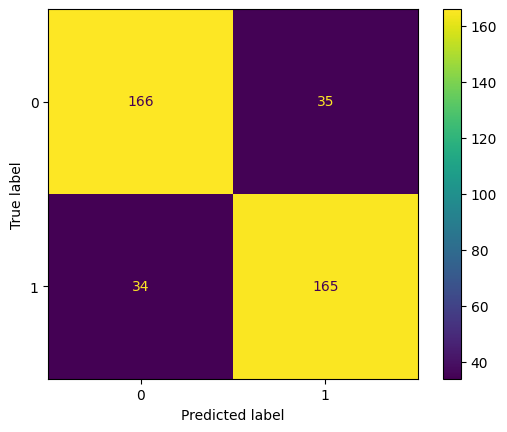

In [62]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
results = classifier.predict(X_test)
print(classification_report(y_test, results))
conf_matrix = confusion_matrix(y_test, results)
conf_matrix = ConfusionMatrixDisplay(conf_matrix)
conf_matrix.plot()
plt.show()


In [83]:
import pandas as pd
df = pd.DataFrame(scores, index=[0])
# set the first row name as "accuracy"
df = df.rename(index={0: "Accuracy:"})
df.head(1)


,MultinomialNB(),SVC(kernel='linear'),"RandomForestClassifier(n_estimators=25, random_state=42)"
Accuracy:,0.8225,0.8275,0.7075
